In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
dataset = pd.read_csv('insurance.csv')
dataset["smoker"] = dataset["smoker"].map({"yes": 1, "no": 0})
dataset["sex"] = dataset["sex"].map({"male": 1, "female": 0})
dataset["region"] = dataset["region"].map({
    "northeast": 0,
    "northwest": 1,
    "southeast": 2,
    "southwest": 3
})
dataset = pd.get_dummies(dataset, columns=["region"], prefix='r', prefix_sep='_')
# 1 hot encoding for smoker?
print(dataset.tail())

      age  sex   bmi  children  smoker  expenses  r_0  r_1  r_2  r_3
1333   50    1  31.0         3       0  10600.55    0    1    0    0
1334   18    0  31.9         0       0   2205.98    1    0    0    0
1335   18    0  36.9         0       0   1629.83    0    0    1    0
1336   21    0  25.8         0       0   2007.95    0    0    0    1
1337   61    0  29.1         0       1  29141.36    0    1    0    0


In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('expenses')
test_labels = test_features.pop('expenses')

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())



[[39.036446    0.49813083 30.737288    1.093458    0.19906542  0.24859811
   0.23551399  0.28130844  0.23457943]]


In [15]:
age = np.array(train_features['age'])
age_normalizer = layers.Normalization(input_shape=[1,], axis=None)
age_normalizer.adapt(age)

age_model = tf.keras.Sequential([
    age_normalizer,
    layers.Dense(units = 1)
])

age_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [17]:
age_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [18]:
history = age_model.fit(
    train_features['age'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,12453.588867,14178.051758,95
96,12450.879883,14175.488281,96
97,12448.143555,14172.862305,97
98,12445.424805,14170.208984,98
99,12442.708008,14167.582031,99


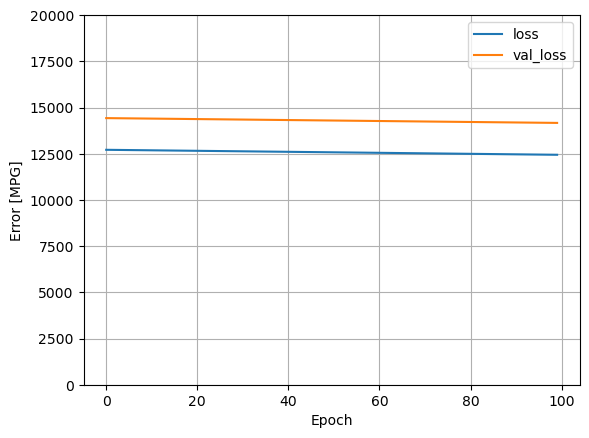

In [21]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 20000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)


In [23]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
#linear_model.predict(train_features[:10])
#linear_model.layers[1].kernel
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [24]:
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

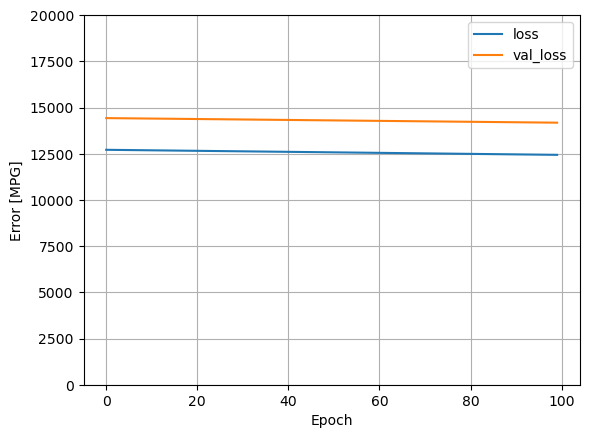

In [27]:
plot_loss(history)


In [57]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(7, activation='relu'),
      layers.Dense(7, activation='relu'),
      layers.Dense(7, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01),
                metrics=['MeanAbsoluteError', 'MeanSquaredError'])
  return model

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 9)                 19        
 tion)                                                           
                                                                 
 dense_18 (Dense)            (None, 7)                 70        
                                                                 
 dense_19 (Dense)            (None, 7)                 56        
                                                                 
 dense_20 (Dense)            (None, 7)                 56        
                                                                 
 dense_21 (Dense)            (None, 1)                 8         
                                                                 
Total params: 209 (840.00 Byte)
Trainable params: 190 (760.00 Byte)
Non-trainable params: 19 (80.00 Byte)
______________

In [58]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

9/9 [==============================] - 0s 6ms/step - loss: 3281.8027 - mean_absolute_error: 3281.8027 - mean_squared_error: 41639820.0000


[3281.802734375, 3281.802734375, 41639820.0]

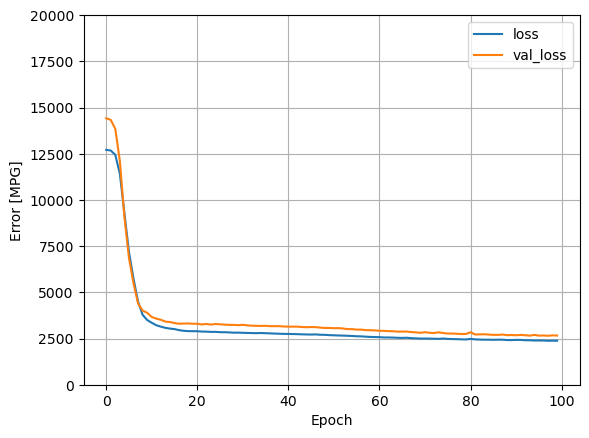

In [ ]:
plot_loss(history)
dnn_model.evaluate(test_features, test_labels)

9/9 - 0s - loss: 3281.8027 - mean_absolute_error: 3281.8027 - mean_squared_error: 41639820.0000 - 203ms/epoch - 23ms/step
Testing set Mean Abs Error: 3281.80 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 6ms/step


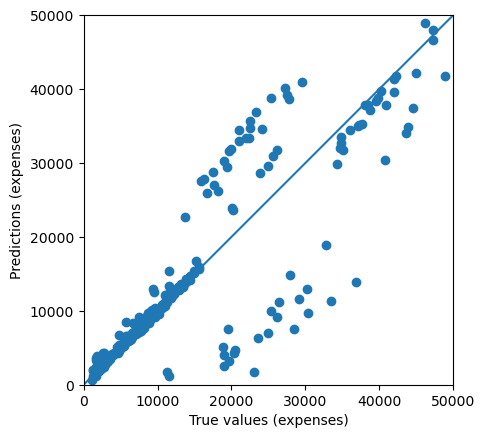

In [64]:
test_dataset = test_features

loss, mae, mse = dnn_model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

test_predictions = dnn_model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)